# Explore the 001 Model Run
- Include static variables
- run the ealstm too

In [173]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
# colormaps = https://matplotlib.org/cmocean/
import cmocean
import matplotlib.pyplot as plt
import geopandas as gpd
from typing import List, Tuple, Dict, Union, Optional

import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 100

import os

# set the working directory
current_path = Path('.').resolve()
if current_path == Path('/home/tommy/ml_drought/notebooks/draft'):
    os.chdir(current_path.parents[1].as_posix())

current_path = Path('.').resolve()
assert current_path.name == "ml_drought"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from scripts.utils import get_data_path
from src.engineer import Engineer

In [364]:
WARNINGS_ON = False

if not WARNINGS_ON:
    print("WARNING: You are turning off all warnings. Are you sure?")
    import warnings
    warnings.filterwarnings('ignore')

In [3]:
from src.utils import get_ds_mask

data_dir = get_data_path()

# Model Run

In [4]:
from src.analysis import read_train_data, read_test_data, read_pred_data
from scripts.analysis import read_all_data, read_all_available_pred_data, load_nn, create_all_error_metrics

In [5]:
experiment = "one_month_forecast"
[d.name for d in (data_dir / f"models/{experiment}").iterdir()]

['previous_month', 'rnn', 'ealstm']

In [9]:
# ealstm = load_nn(data_dir, model_str="ealstm", experiment=experiment)
# ealstm.ignore_vars

In [10]:
# read train/test data
X_train, y_train, X_test, y_test = read_all_data(
    data_dir, static=True, experiment=experiment
)

mask = get_ds_mask(X_train.VCI)
test_da = y_test[list(y_test.data_vars)[0]]

In [11]:
# read the predicted data
predictions = read_all_available_pred_data(data_dir, experiment=experiment)

# predictions = {}
# for model in ["previous_month", "linear_network", "rnn"]:
#     da = xr.open_dataset(data_dir / f"000_models/one_month_forecast/{model}_preds.nc")
#     predictions[model] = da[[v for v in da.data_vars][0]]

#  check that the shapes of all predictions are the same
assert set([predictions[m].shape for m in predictions.keys()]).__len__() == 1
preds = predictions[list(m for m in predictions.keys())[0]]

# get the matching shapes from predictions and test data
test_da = test_da.sel(lat=preds.lat, lon=preds.lon, time=preds.time)

### Calculate Error Metrics

In [12]:
rmse_dict, r2_dict = create_all_error_metrics(predictions, test_da)

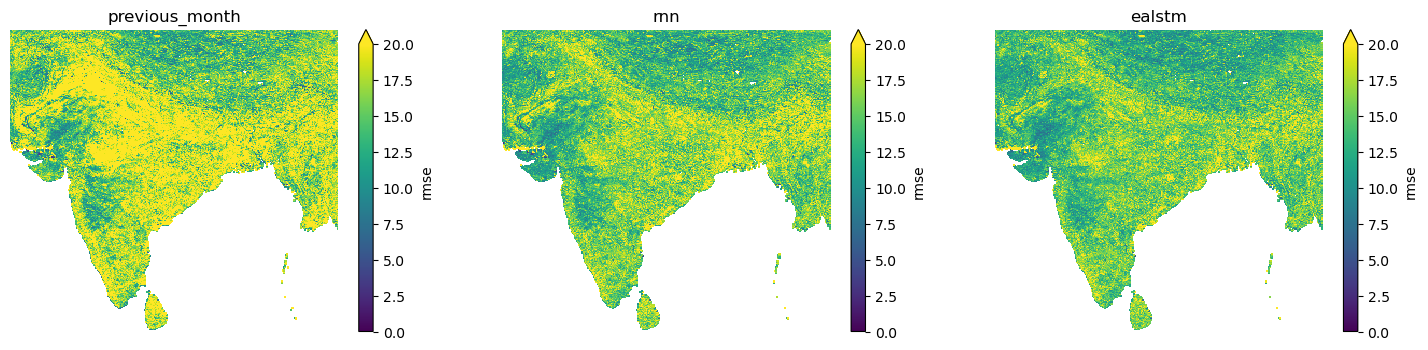

In [13]:
kwargs = dict(vmin=0, vmax=20, cmap="viridis")

fig, axs = plt.subplots(1, 3, figsize=(6*3, 4))
for i, key in enumerate(rmse_dict.keys()):
    ax = axs[i]
    rmse_dict[key].plot(ax=ax, **kwargs)
    ax.set_title(str(key))  
    ax.axis('off')

# Join Metrics to Region DataFrame

In [14]:
l1_gdf = gpd.read_file(data_dir / "raw/boundaries/india/IND_adm1.shp")
l2_gdf = gpd.read_file(data_dir / "raw/boundaries/india/IND_adm2.shp")

l1_mask = xr.open_dataset(data_dir / "analysis/boundaries_preprocessed/state_l1_india.nc")
l2_mask = xr.open_dataset(data_dir / "analysis/boundaries_preprocessed/district_l2_india.nc")

l1_lookup = dict(zip(
    [int(k.lstrip().rstrip()) for k in l1_mask.attrs["keys"].split(',')], 
    [k.lstrip().rstrip() for k in l1_mask.attrs["values"].split(',')]
))
l2_lookup = dict(zip(
    [int(k.lstrip().rstrip()) for k in l2_mask.attrs["keys"].split(',')], 
    [k.lstrip().rstrip() for k in l2_mask.attrs["values"].split(',')]
))

### Creating the R2/RMSE GeoDataFrames

In [15]:
from scripts.analysis import get_mean_timeseries_per_region

In [221]:
assert (data_dir / "tommy").exists(), "Require data_dir / 'tommy' to save csv copy of data"

# takes a while to run so save it if it doesn't exist already
if not (data_dir / "tommy/l1_state_mean_timeseries_001.csv").exists():
    state_df = get_mean_timeseries_per_region(level=1)
    state_df.to_csv(data_dir / "tommy/l1_state_mean_timeseries_001.csv")
else:
    state_df = pd.read_csv(data_dir / "tommy/l1_state_mean_timeseries_001.csv").drop("Unnamed: 0", axis=1)

In [227]:
if not (data_dir / "tommy/l2_district_mean_timeseries_001.csv").exists():
    district_df = get_mean_timeseries_per_region(level=2)
    district_df.to_csv(data_dir / "tommy/l2_district_mean_timeseries_001.csv")
else:
    district_df = pd.read_csv(data_dir / "tommy/l2_district_mean_timeseries_001.csv").drop("Unnamed: 0", axis=1)

In [17]:
from scripts.analysis import create_mean_pixel_errors_gdf

In [18]:
## -- Level 1 --
l1_rmse_gdf = create_mean_pixel_errors_gdf(
    metric_dict=rmse_dict,
    region_gdf=l1_gdf,
    gdf_name_col="NAME_1",
    region_mask=l1_mask,
)

l1_r2_gdf = create_mean_pixel_errors_gdf(
    metric_dict=r2_dict,
    region_gdf=l1_gdf,
    gdf_name_col="NAME_1",
    region_mask=l1_mask,
)


## -- Level 2 --
l2_rmse_gdf = create_mean_pixel_errors_gdf(
    metric_dict=rmse_dict,
    region_gdf=l2_gdf,
    gdf_name_col="NAME_2",
    region_mask=l2_mask,
)

l2_r2_gdf = create_mean_pixel_errors_gdf(
    metric_dict=r2_dict,
    region_gdf=l2_gdf,
    gdf_name_col="NAME_2",
    region_mask=l2_mask,
)

/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis,

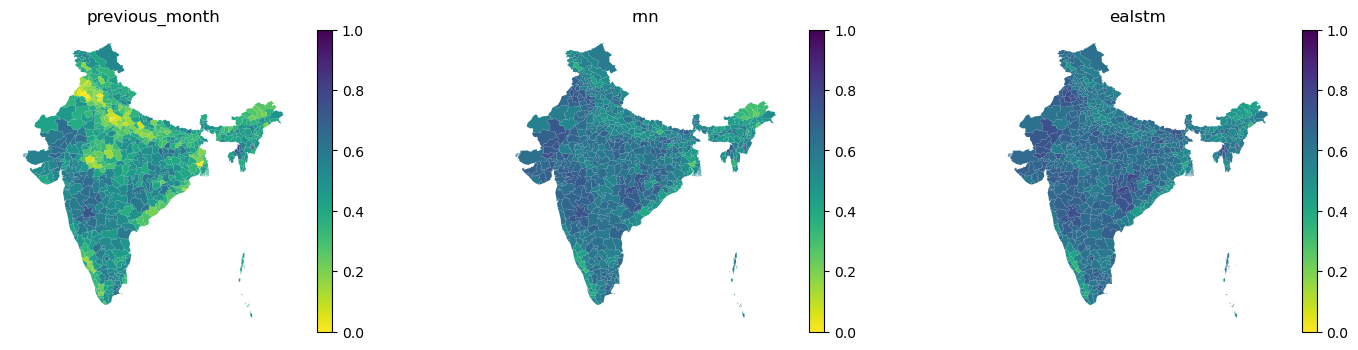

In [19]:
kwargs = {"vmin": 0, "vmax": 1, "cmap": "viridis_r"}

fig, axs = plt.subplots(1, 3, figsize=(6*3, 4))
for i, model in enumerate([c for c in l2_r2_gdf.columns if c not in ["region_name", "geometry", "index"]]):
    ax = axs[i]
    l2_r2_gdf.plot(model, legend=True, ax=ax, **kwargs)
    ax.set_title(model)
    
    ax.axis('off')

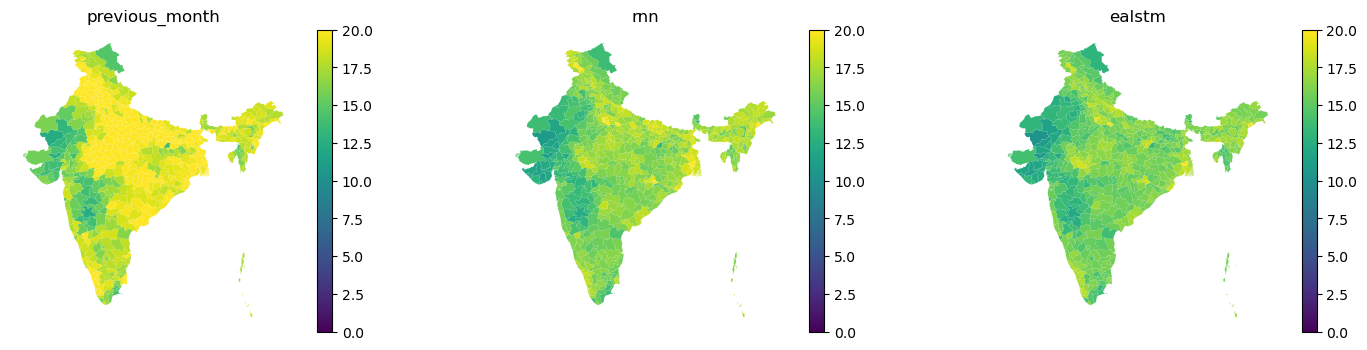

In [20]:
kwargs = {"vmin": 0, "vmax": 20, "cmap": "viridis"}

fig, axs = plt.subplots(1, 3, figsize=(6*3, 4))
for i, model in enumerate([c for c in l2_r2_gdf.columns if c not in ["region_name", "geometry", "index"]]):
    ax = axs[i]
    l2_rmse_gdf.plot(model, legend=True, ax=ax, **kwargs)
    ax.set_title(model)
    
    ax.axis('off')

### Mean of Predictions per Area

In [293]:
from scripts.analysis import calculate_error_of_mean_predictions

In [295]:
l1_mean_pred_scores = calculate_error_of_mean_predictions(
    region_mean_df = state_df,
    region_gdf = l1_gdf,
    gdf_name_col = "NAME_1",
    monthly_averages = False
)

l1_mean_pred_scores

/home/tommy/ml_drought/scripts/analysis.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_mean_df["datetime"] = pd.to_datetime(region_mean_df["datetime"])


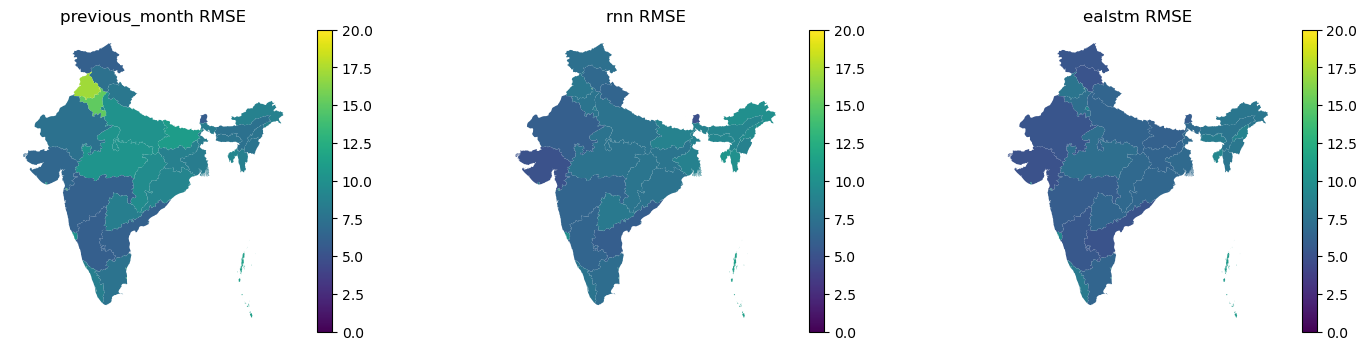

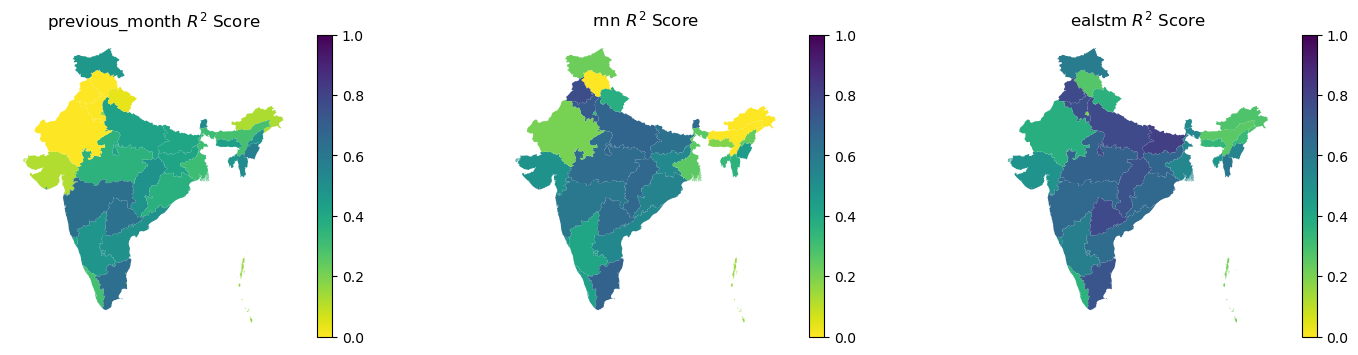

In [300]:
fig, axs = plt.subplots(1, 3, figsize=(6*3, 4))

for ix, model in enumerate(["previous_month","rnn", "ealstm"]):
    ax = axs[ix]
    l1_mean_pred_scores.loc[l1_mean_pred_scores["model"] == model].plot("rmse", legend=True, vmin=0, vmax=20, ax=ax)
    ax.axis('off')
    ax.set_title(f"{model} RMSE")
    
fig, axs = plt.subplots(1, 3, figsize=(6*3, 4))
for ix, model in enumerate(["previous_month", "rnn", "ealstm"]):
    ax = axs[ix]
    l1_mean_pred_scores.loc[l1_mean_pred_scores["model"] == model].plot("r2_score", legend=True, vmin=0, vmax=1, ax=ax, cmap="viridis_r")
    ax.axis('off')
    ax.set_title(f"{model} $R^2$ Score")

# Creating seasonal errors

### Mean of Predictions per month
$$error ( \texttt{spacetime_mean}(obs), \texttt{spacetime_mean}(pred) ) $$

In [421]:
l1_monmean_pred_scores = calculate_error_of_mean_predictions(
    region_mean_df = state_df,
    region_gdf = l1_gdf,
    gdf_name_col = "NAME_1",
    monthly_averages = True
)
l1_monmean_pred_scores["month"] = l1_monmean_pred_scores["datetime"].astype(int)

l2_monmean_pred_scores = calculate_error_of_mean_predictions(
    region_mean_df = district_df,
    region_gdf = l2_gdf,
    gdf_name_col = "NAME_2",
    monthly_averages = True
)
l2_monmean_pred_scores["month"] = l2_monmean_pred_scores["datetime"].astype(int)

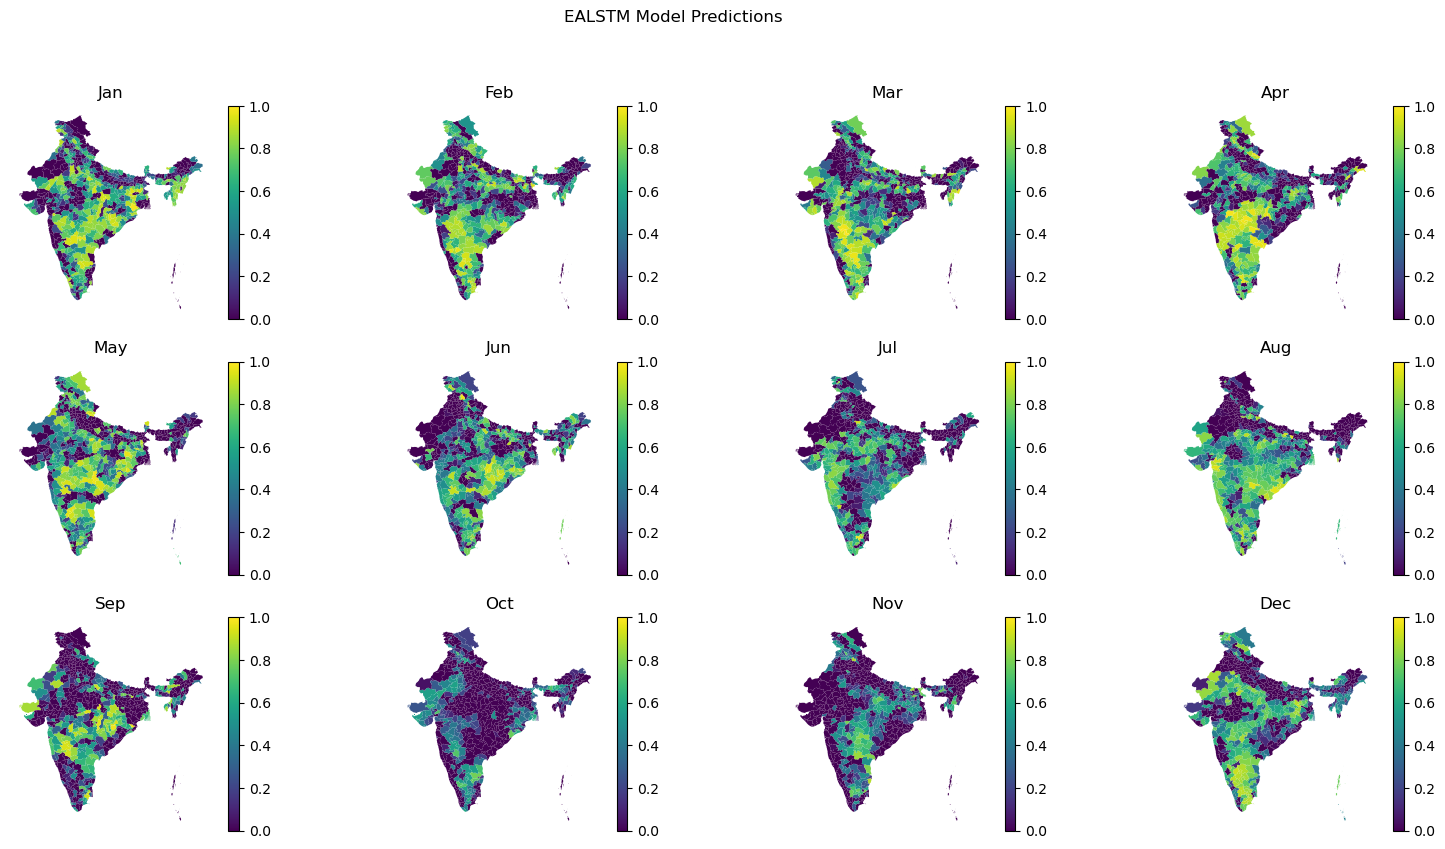

In [427]:
import calendar 
scale = 0.8
fig, axs = plt.subplots(3, 4, figsize=(6*scale*4, 4*scale*3))

for mth in range(1, 13):
    ax = axs[np.unravel_index(mth-1, (3, 4))]
    l2_monmean_pred_scores.query(f"(model == 'ealstm') & month == {mth}").plot("r2_score", vmin=0, vmax=1, legend=True, ax=ax)
    ax.axis('off')
    ax.set_title(calendar.month_abbr[mth])
    
fig.suptitle("EALSTM Model Predictions");

### Mean of Pixel Errors per month
$$ mean( error(obs, pred) ) $$

In [484]:
from scripts.analysis import create_all_temporal_error_metrics
from src.utils import drop_nans_and_flatten

In [525]:
pixel_mon_rmse, pixel_mon_r2 = create_all_temporal_error_metrics(
    predictions=predictions,
    y_test=test_da,
)
pixel_mon_rmse["ealstm"]

<xarray.DataArray 'monthly_rmse' (time: 12, lat: 302, lon: 305)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [14.31430048, 11.61398394, 13.34842255, ...,  8.10229831,
         10.2135455 , 19.67777295],
        [15.55568093, 22.71838799, 12.54796575, ..., 17.85259833,
         12.95566633,  6.35770845],
        [15.46053087, 21.43294994, 24.86419876, ...,  8.74166814,
         13.02062342, 17.42551406]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [18.70932183, 15.81740141,  6.95001441, ..., 11.41258031,
          6.19430534, 17.4810765 ],
        [22.18375329, 13.28986712, 12.13593761, ..., 15.49603199,
          8.78663332, 14.10831107],
        [ 8.30047844,  3.2775668 , 20.69122573, ..., 13.44068728,
         16.68748146, 16.56010287]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 6.30718473,  1.9995752 ,  5.57699933, ..., 14.46476378,
         26.63659739, 14.31590068],
        [ 3.91796628,  2.77789124,  7.81858757, ..., 13.74309386,
         13.72747579, 21.56596272],
        [11.29958076,  6.36120544, 23.59775705, ..., 19.87042427,
         12.03906693, 13.24029553]],

       ...,

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [14.76634804,  3.9356531 ,  8.99849496, ..., 15.89943377,
         26.43650084,  6.10032751],
        [12.95078388, 16.17839996, 11.83449901, ...,  9.92735185,
          8.13394545,  9.55787505],
        [ 7.84206358, 17.26138789, 14.30390468, ...,  9.8364665 ,
          9.51543915,  7.91455029]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [11.21655227, 17.32470975, 12.57358661, ..., 25.01463926,
         20.93220088, 21.25852949],
        [ 8.83099813,  9.24194935,  9.89715911, ..., 26.56375529,
         29.70925025, 34.20449216],
        [12.18254963, 10.4255699 , 14.80454166, ..., 17.00537042,
         25.44604617, 22.49790238]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [16.42343649, 15.6117634 , 18.28904151, ..., 17.90609958,
         10.70663528,  9.77789342],
        [10.1250317 , 15.83141479, 19.38997505, ..., 11.04823194,
          3.7671724 ,  5.83394578],
        [ 6.34169333,  6.07555891, 18.79367777, ...,  4.33144033,
         13.58968369,  8.06948997]]])
Coordinates:
  * lon      (lon) float64 67.3 67.4 67.5 67.6 67.7 ... 97.3 97.4 97.5 97.6 97.7
  * lat      (lat) float64 5.8 6.0 6.1 6.2 6.3 6.4 ... 35.6 35.7 3

In [568]:
median_score

0.7652730191685454

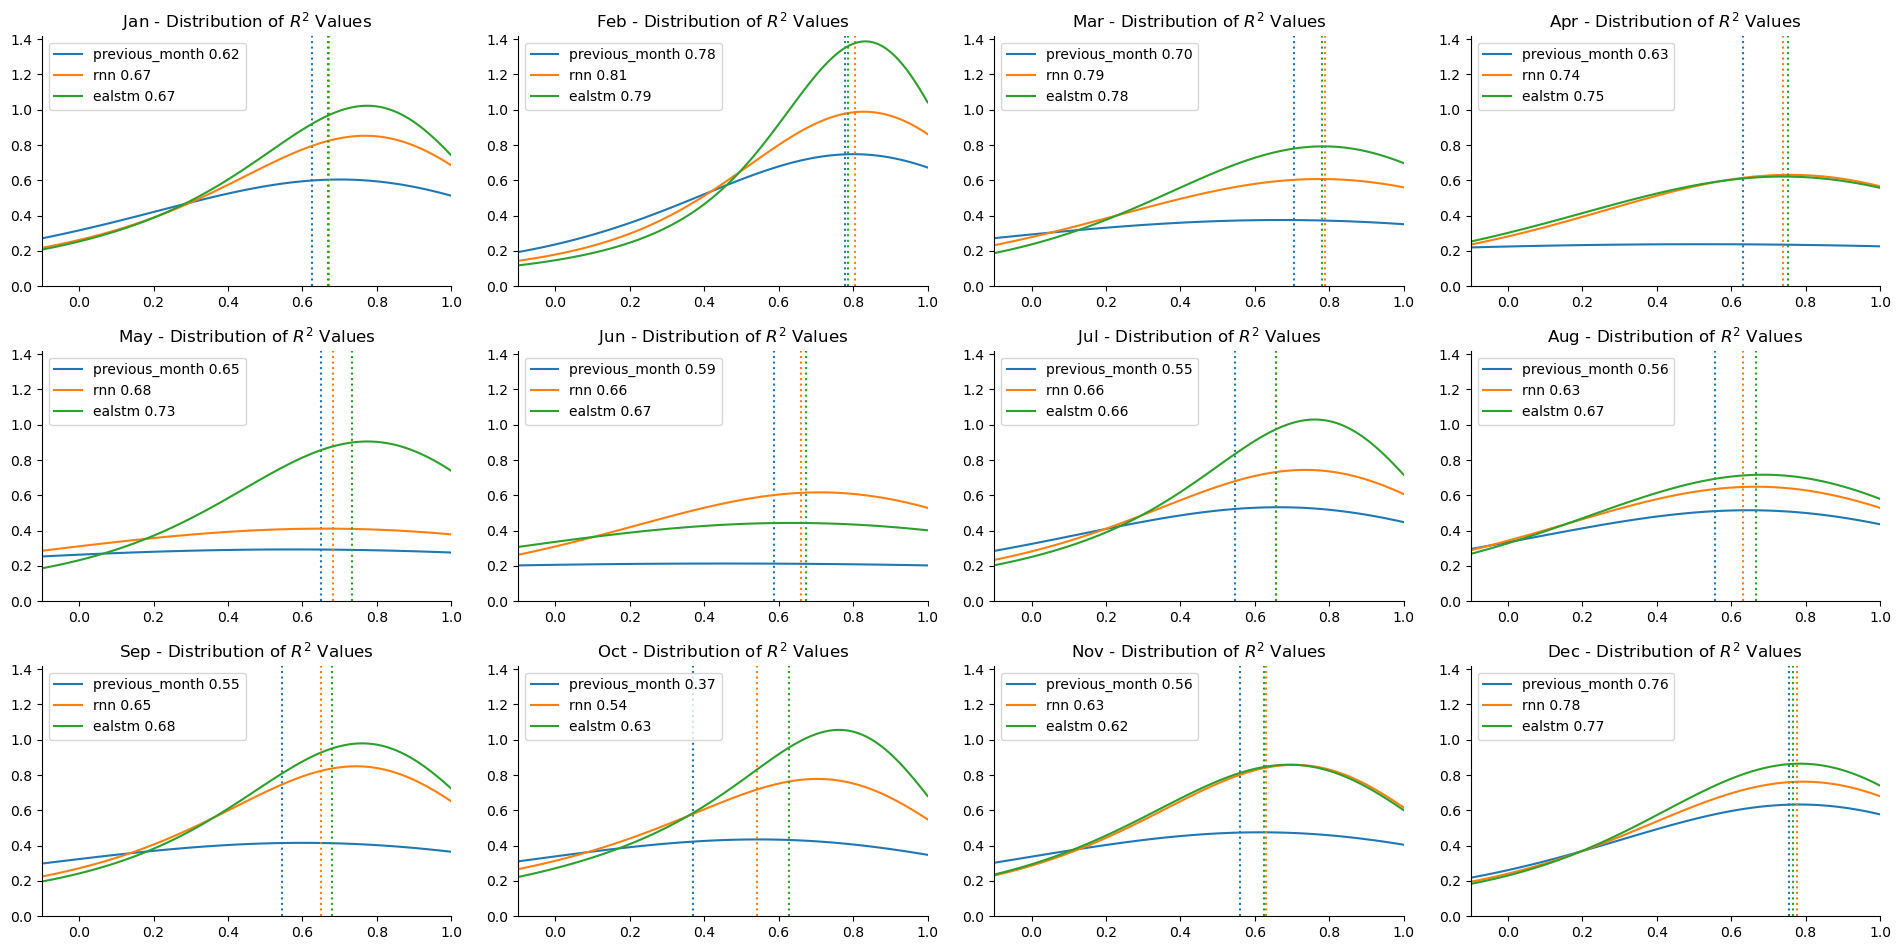

In [572]:
fig, axs = plt.subplots(3, 4, figsize=(6*scale*4, 4*scale*3))

for mth in np.arange(1, 13):
    ax = axs[np.unravel_index(mth-1, (3, 4))]
    
    for ix, model in enumerate(pixel_mon_r2.keys()):
        model_r2 = pixel_mon_r2[model].sel(time=mth)
        color = sns.color_palette()[ix]
        median_score = float(model_r2.median().values)
        sns.distplot(
            drop_nans_and_flatten(model_r2), 
            hist=False,
            kde_kws={"clip": (-0.1, 1)}, 
            ax=ax, 
            label=f"{model} {median_score:.2f}", 
            color=color
        )
        ax.axvline(median_score, color=color, ls=":")

    ax.set_xlim(-0.1, 1)
    ax.set_ylim(0, 1.42)
    ax.set_title(f"{calendar.month_abbr[mth]} - Distribution of $R^2$ Values")
    ax.legend()
    sns.despine()

plt.tight_layout()

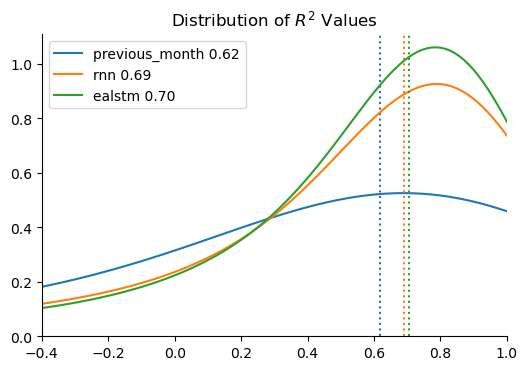

In [573]:
fig, ax = plt.subplots()

for ix, model in enumerate(pixel_mon_r2.keys()):
    model_r2 = pixel_mon_r2[model]
    color = sns.color_palette()[ix]
    median_score = float(model_r2.median().values)
    sns.distplot(
        drop_nans_and_flatten(model_r2), 
        hist=False,
#         bins = np.linspace(-0.4, 1, 100),
#         hist_kws={"range": (-0.4, 1),},
        kde_kws={"clip": (-0.4, 1)}, 
        ax=ax, 
        label=f"{model} {median_score:.2f}", 
        color=color
    )
    ax.axvline(median_score, color=color, ls=":")
    
ax.set_xlim(-0.4, 1)
ax.set_title("Distribution of $R^2$ Values")
ax.legend()
sns.despine()

In [553]:
# for ix, model in enumerate(pixel_mon_r2.keys()):
all_mth_values = []
for mth in np.arange(1, 13):
    all_mth_values.append(drop_nans_and_flatten(pixel_mon_r2[model].sel(time=mth)))
    
all_mth_values = pd.DataFrame(all_mth_values).T
all_mth_values = all_mth_values.rename(dict(zip(np.arange(12), np.arange(1, 13))), axis=1)

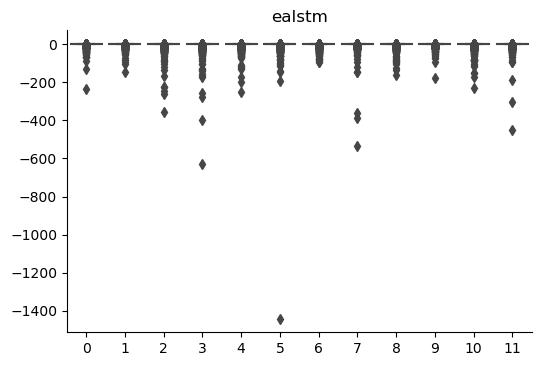

In [562]:
fig, ax = plt.subplots()
sns.boxplot(data=all_mth_values, orient="v", ax=ax)
ax.set_title(model)
# plt.yscale('log')
sns.despine()

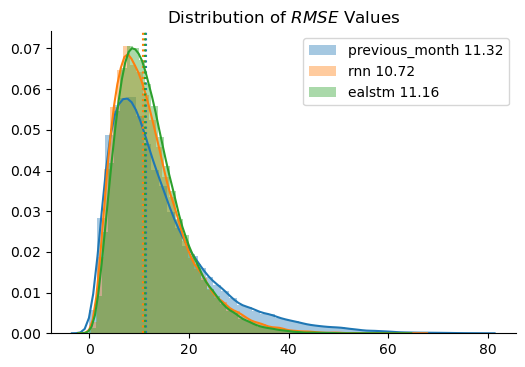

In [575]:
fig, ax = plt.subplots()

for ix, model in enumerate(pixel_mon_rmse.keys()):
    model_rmse = pixel_mon_rmse[model].sel(time=mth)
    color = sns.color_palette()[ix]
    median_score = float(model_rmse.median().values)
    sns.distplot(
        drop_nans_and_flatten(model_rmse), 
        # hist_kws={"range": (-0.4, 1)}, 
        ax=ax, 
        label=f"{model} {median_score:.2f}", 
        norm_hist=True, 
        color=color
    )  #  kde_kws={"clip": (0, 1)}, 
    ax.axvline(median_score, color=color, ls=":")
    
# ax.set_xlim(-0.4, 1)
ax.set_title("Distribution of $RMSE$ Values")
ax.legend()
sns.despine()

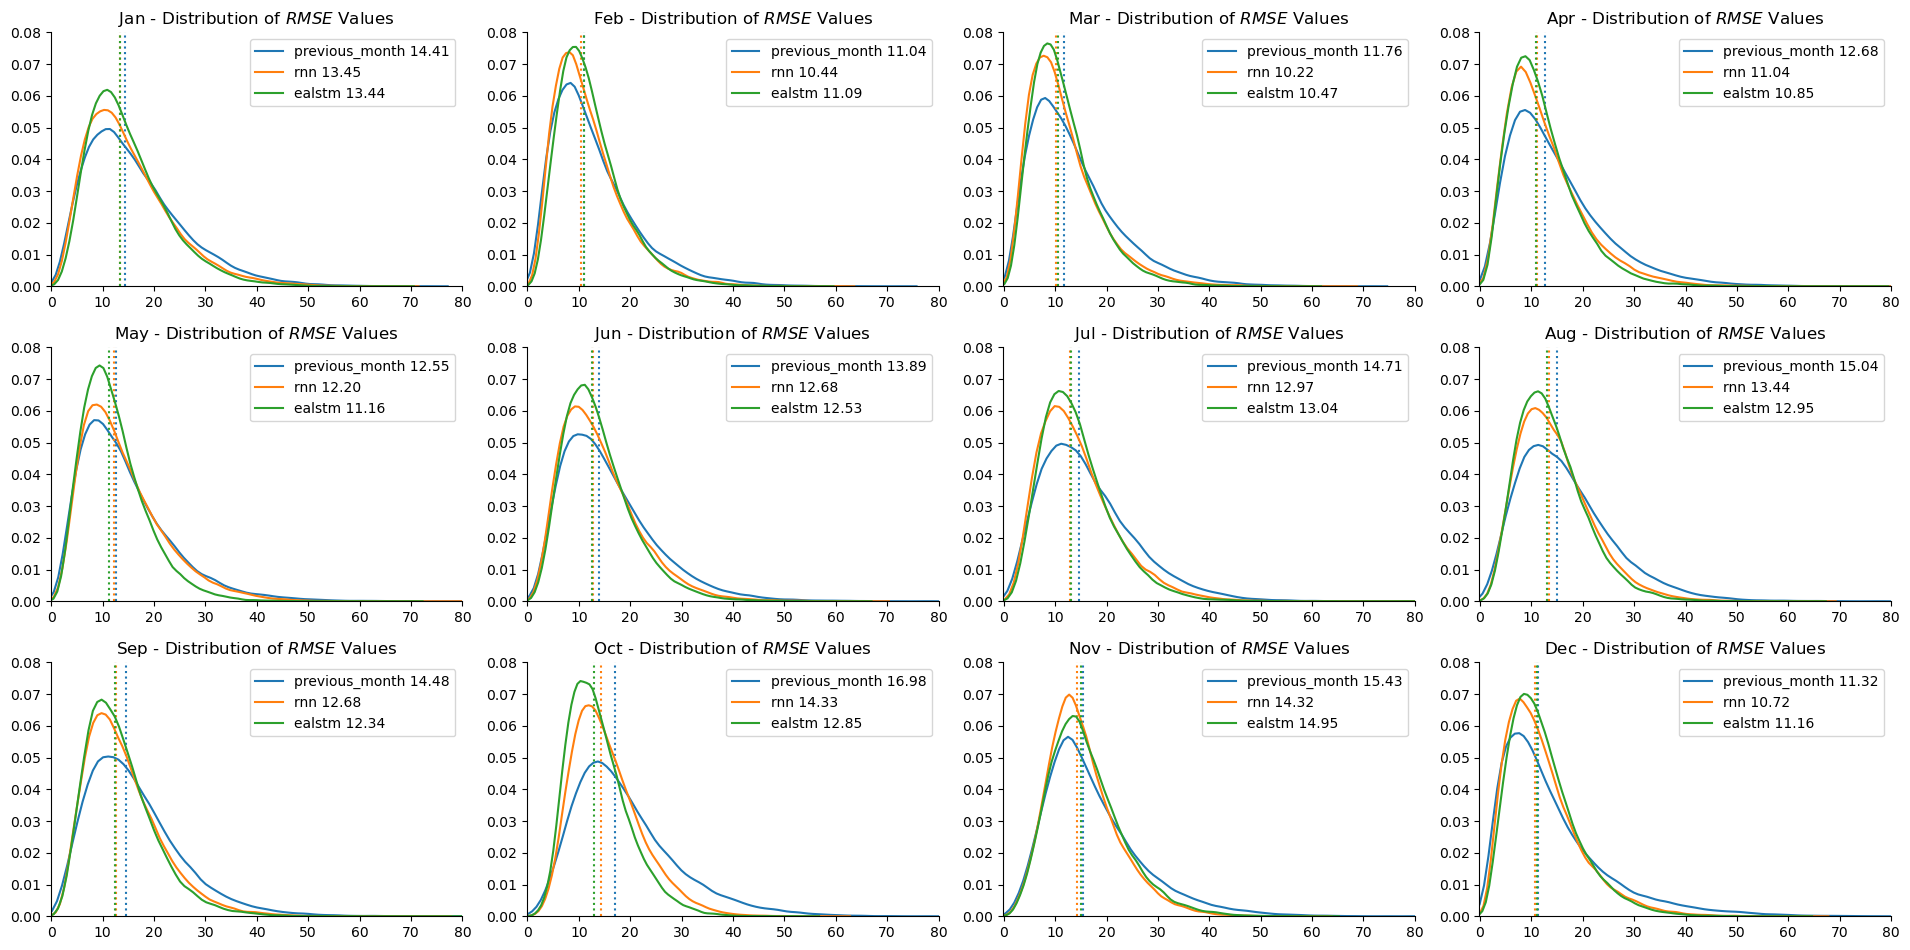

In [578]:
fig, axs = plt.subplots(3, 4, figsize=(6*scale*4, 4*scale*3))

for mth in np.arange(1, 13):
    ax = axs[np.unravel_index(mth-1, (3, 4))]
    
    for ix, model in enumerate(pixel_mon_rmse.keys()):
        model_rmse = pixel_mon_rmse[model].sel(time=mth)
        color = sns.color_palette()[ix]
        median_score = float(model_rmse.median().values)
        sns.distplot(
            drop_nans_and_flatten(model_rmse), 
            # hist_kws={"range": (-0.4, 1)}, 
            hist=False,
            ax=ax, 
            label=f"{model} {median_score:.2f}", 
            norm_hist=True, 
            color=color
        )  #  kde_kws={"clip": (0, 1)}, 
        ax.axvline(median_score, color=color, ls=":")

    ax.set_xlim(-0.1, 80)
    ax.set_ylim(0, 0.08)
    ax.set_title(f"{calendar.month_abbr[mth]} - Distribution of $RMSE$ Values")

    ax.legend()
    sns.despine()

plt.tight_layout()

## Comparison of different metrics

In [428]:
l1_monmean_pred_scores.head()
l2_monmean_pred_scores.head()

,datetime,model,rmse,r2_score,geometry,month
Adilabad,01,ealstm,3.614110,0.846745,"POLYGON ((78.33625 19.88319, 78.34669 19.88140...",1
Adilabad,01,previous_month,5.245676,0.677140,"POLYGON ((78.33625 19.88319, 78.34669 19.88140...",1
Adilabad,01,rnn,4.982901,0.708676,"POLYGON ((78.33625 19.88319, 78.34669 19.88140...",1
Adilabad,02,ealstm,7.155314,0.651721,"POLYGON ((78.33625 19.88319, 78.34669 19.88140...",2
Adilabad,02,previous_month,4.247283,0.877287,"POLYGON ((78.33625 19.88319, 78.34669 19.88140...",2


In [432]:
l2_monmeans = l2_monmean_pred_scores[["month", "model", "rmse", "r2_score"]].groupby(["month", "model"]).mean()
l1_monmeans = l1_monmean_pred_scores[["month", "model", "rmse", "r2_score"]].groupby(["month", "model"]).mean()

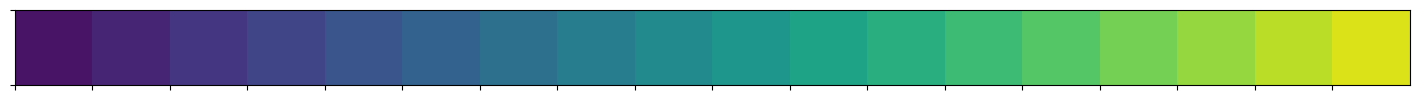

In [519]:
sns.palplot(sns.color_palette('viridis', 18))

In [520]:
colors = sns.color_palette('viridis', 18)
c_lkup = {
    "ealstm_l1": colors[0], 
    "ealstm_l2": colors[3], 
    "rnn_l1": colors[13], 
    "rnn_l2": colors[14], 
    "previous_month_l1": colors[16], 
    "previous_month_l2": colors[17], 
}

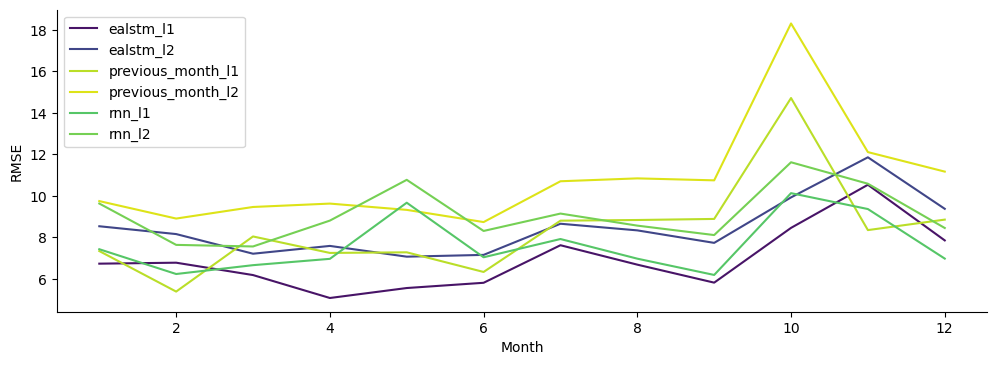

In [521]:
fig, ax = plt.subplots(figsize=(12, 4))

for model in l1_monmeans.reset_index().model.unique():
    df1 = l1_monmeans.reset_index().query(f"model == '{model}'")
    df2 = l2_monmeans.reset_index().query(f"model == '{model}'")
    months = np.arange(1, 13)
    ax.plot(months, df1["rmse"], color=c_lkup[f"{model}_l1"], label=f"{model}_l1")
    ax.plot(months, df2["rmse"], color=c_lkup[f"{model}_l2"], label=f"{model}_l2")
    
ax.legend()
ax.set_ylabel("RMSE")
ax.set_xlabel("Month")
sns.despine()

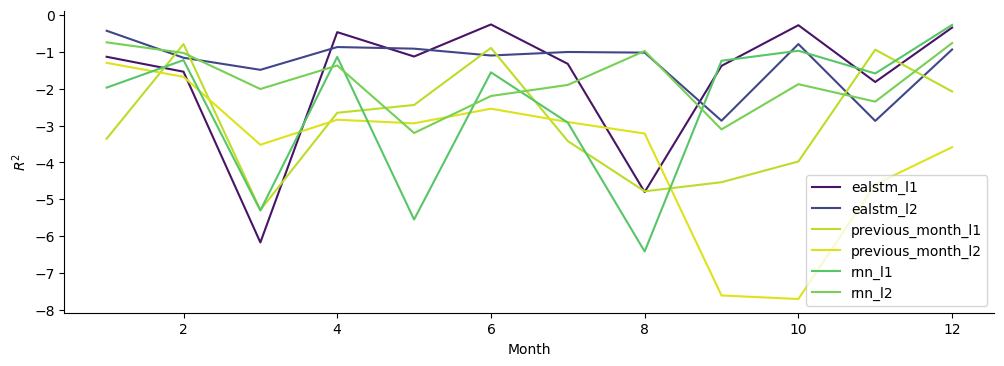

In [522]:
fig, ax = plt.subplots(figsize=(12, 4))

for model in l1_monmeans.reset_index().model.unique():
    df1 = l1_monmeans.reset_index().query(f"model == '{model}'")
    df2 = l2_monmeans.reset_index().query(f"model == '{model}'")
    months = np.arange(1, 13)
    ax.plot(months, df1["r2_score"], color=c_lkup[f"{model}_l1"], label=f"{model}_l1")
    ax.plot(months, df2["r2_score"], color=c_lkup[f"{model}_l2"], label=f"{model}_l2")
    
ax.legend()
ax.set_ylabel("$R^2$")
ax.set_xlabel("Month")
sns.despine()

## Monthly Mean Errors over each AdminUnit

### STATE L1

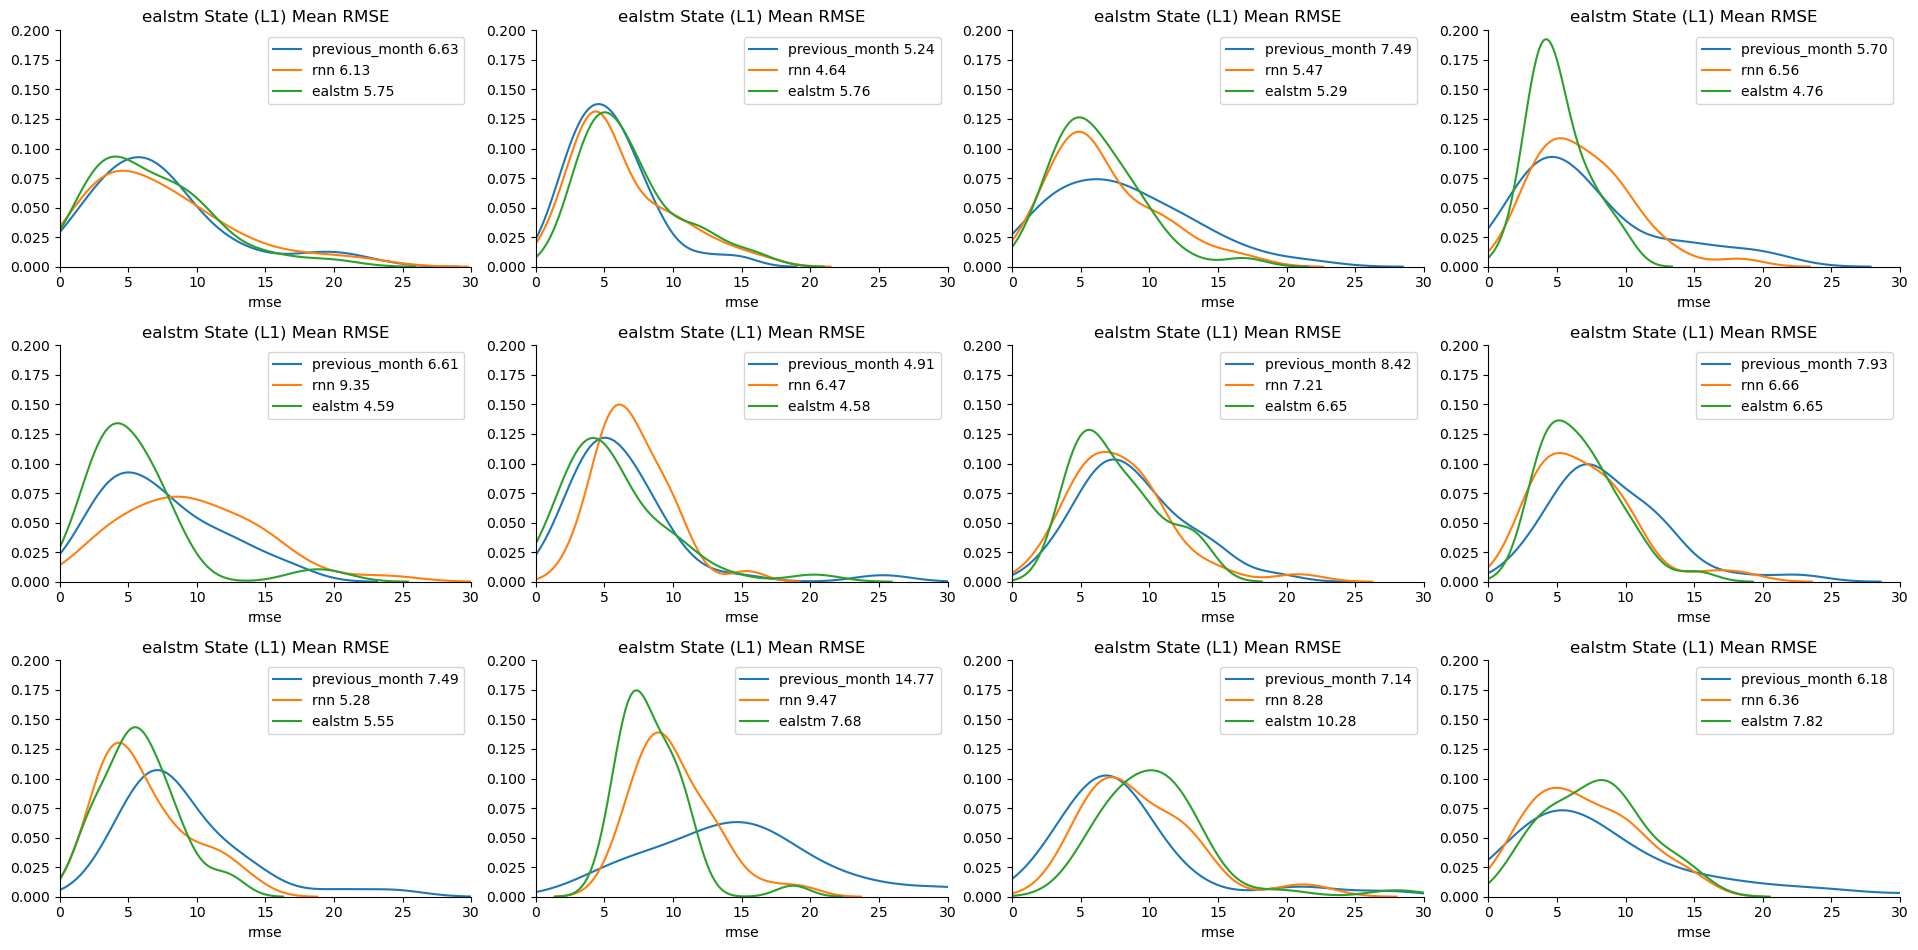

In [670]:
fig, axs = plt.subplots(3, 4, figsize=(6*scale*4, 4*scale*3))

for mth in np.arange(1, 13):
    ax = axs[np.unravel_index(mth-1, (3, 4))]
    
    for ix, model in enumerate(pixel_mon_rmse.keys()):
        data = l1_monmean_pred_scores.query(f"(model == '{model}') & (month == {mth})").rmse
        median_score = float(data.median())
        sns.distplot(
            data,
            kde_kws={"clip": (0, 30)},
            ax=ax,
            hist=False,
            label=f"{model} {median_score:.2f}",
        )

    ax.set_xlim(0, 30)
    ax.set_ylim(0, 0.2)
    ax.set_title(f"{model} State (L1) Mean RMSE")
    ax.legend()
    sns.despine()
    
plt.tight_layout()

### District L2

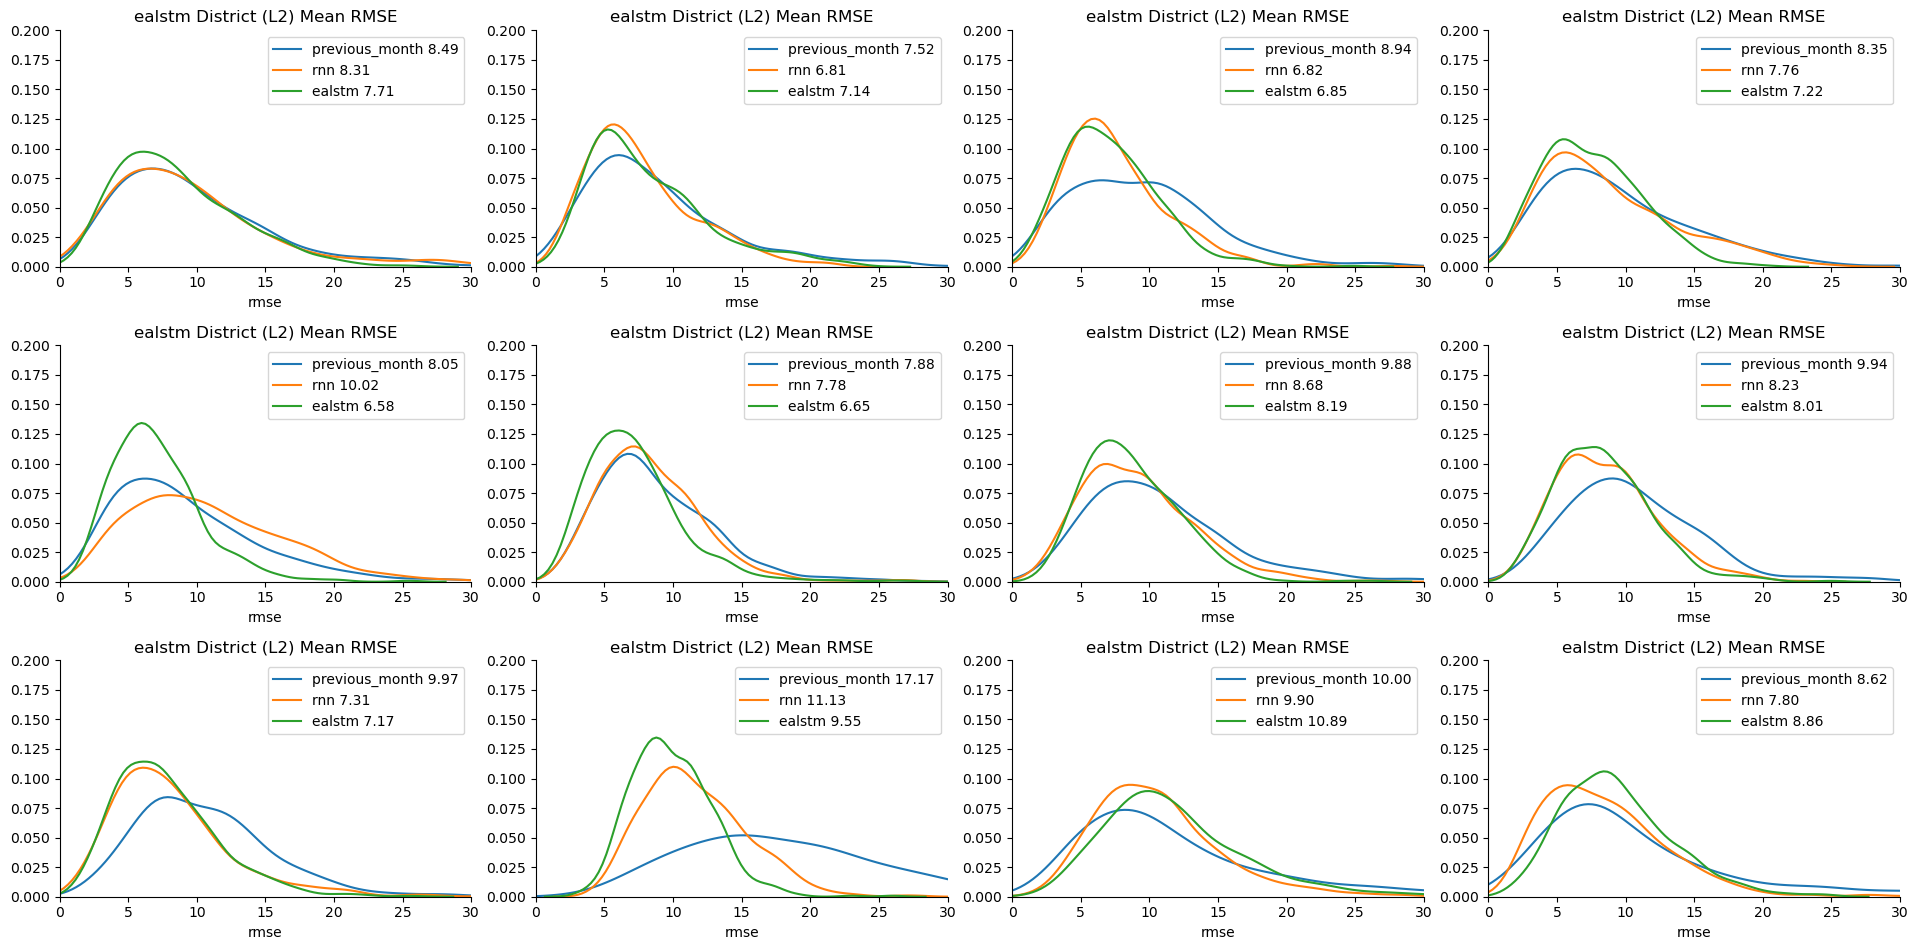

In [671]:
fig, axs = plt.subplots(3, 4, figsize=(6*scale*4, 4*scale*3))

for mth in np.arange(1, 13):
    ax = axs[np.unravel_index(mth-1, (3, 4))]
    
    for ix, model in enumerate(pixel_mon_rmse.keys()):
        data = l2_monmean_pred_scores.query(f"(model == '{model}') & (month == {mth})").rmse
        median_score = float(data.median())
        sns.distplot(
            data,
            kde_kws={"clip": (0, 30)},
            ax=ax,
            hist=False,
            label=f"{model} {median_score:.2f}",
        )

    ax.set_xlim(0, 30)
    ax.set_ylim(0, 0.2)
    ax.set_title(f"{model} District (L2) Mean RMSE")
    ax.legend()
    sns.despine()
    
plt.tight_layout()